# Notebook 03 - PARTE 1: Limpieza y Tratamiento de Missing Values


## Índice (Parte 1)
1. [Objetivo](#objetivo)
2. [Carga de Datos](#carga)
3. [Identificación de Valores Imposibles](#valores-imposibles)
4. [Reemplazo de Ceros por NaN](#reemplazo)
5. [Análisis de Patrones de Missing](#patron-missing)
6. [Estrategias de Imputación](#imputacion)
   - 6.1 [Imputación por Media/Mediana](#media-mediana)
   - 6.2 [Imputación por KNN](#knn)
   - 6.3 [Comparación de Métodos](#comparacion)
7. [Validación de Imputación](#validacion)
8. [Guardar Datos Limpios](#guardar)

**NOTA:** Este notebook se divide en 2 partes:
- **PARTE 1 (este archivo):** Limpieza y missing values
- **PARTE 2 (siguiente archivo):** Transformaciones, normalización y splits


**¿Qué haremos en esta parte?**
- Correguir el problema crítico identificado en EDA: **ceros imposibles**
- Decidir estrategia de imputación óptima
- Implementar imputación con múltiples métodos
- Comparar resultados y elejir mejor enfoque
- Preparar dataset limpio para transformaciones

**Recordatorio del EDA:**
- Insulin: 48.7% ceros (CRITÍCO)
- SkinThickness: 29.6% ceros
- BloodPressure: 4.6% ceros
- BMI: 1.4% ceros
- Glucose: 0.6% ceros

**Decisión clave:** ¿Imputar o eliminar?
- Eliminar -> perdemos ~50% de datos (inaceptable)
- Imputar -> mantenemos información, introducimos estimaciones

In [1]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Imputación
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer # Necesario para IterativeImputer
from sklearn.impute import IterativeImputer

# Estadística
from scipy import stats

# Utilidades 
import warnings
from pathlib import Path
import copy

# Configuarción
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

# Estilo visual
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = 11

#Crear directorios
FIGURES_DIR = Path('../reports/figures')
DATA_PROCESSED = Path('../data/processed')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

print("Librerías importadas correctamente!")
print(f"Directorios creados: {FIGURES_DIR}, {DATA_PROCESSED}")

Librerías importadas correctamente!
Directorios creados: ..\reports\figures, ..\data\processed


In [2]:
# CARGA DEL DATASET ORIGINAL
df_original = pd.read_csv('../data/raw/diabetes.csv')

print("=" * 80)
print("DATASET ORIGINAL CARGADO")
print("=" * 80)
print(f'\nDimenciones: {df_original.shape[0]} filas x {df_original.shape[1]} columnas')

# Crear copia para trabajar (matener original intacto)
df = df_original.copy()

# Separar features y target 
features_cols = [col for col in df.columns if col != 'Outcome']
target_col = 'Outcome'

print(f'Features: {len(features_cols)}')
print(f'Target: {target_col}')

display(df.head())

DATASET ORIGINAL CARGADO

Dimenciones: 768 filas x 9 columnas
Features: 8
Target: Outcome


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Identificación de Valores Imposibles {#valores-imposibles}

ANÁLIS DETALLADO DE VALORES CERO (BIOLÓGICAMENTE IMPOSIBLES)


,Variable,Ceros,% Ceros,Min (sin ceros),Media (sin ceros),Mediana (sin ceros)
3,Insulin,374,48.697917,14.000000,155.548223,125.000000
2,SkinThickness,227,29.557292,7.000000,29.153420,29.000000
1,BloodPressure,35,4.557292,24.000000,72.405184,72.000000
4,BMI,11,1.432292,18.200000,32.457464,32.300000
0,Glucose,5,0.651042,44.000000,121.686763,117.000000



RESUMEN
Total de ceros problemáticos: 652
Registros afectados: 376(49.0%)


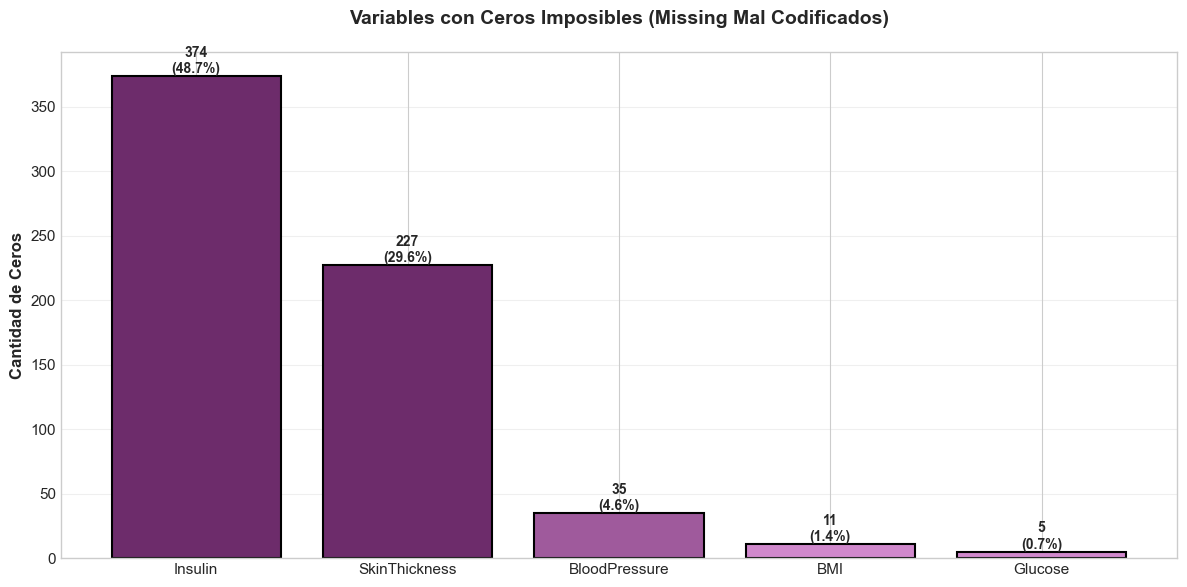


Gráfico guardado: ..\reports\figures\03_zeros_analysis.png


In [3]:
print("ANÁLIS DETALLADO DE VALORES CERO (BIOLÓGICAMENTE IMPOSIBLES)")

cannot_be_zero = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

zero_analysis = []
for col in cannot_be_zero:
    zeros = (df[col] == 0 ).sum()
    pct = (zeros / len(df) * 100)

    # Estadisticas sin los ceros
    data_sin_ceros = df[df[col] > 0][col]

    zero_analysis.append({
        'Variable':col,
        'Ceros':zeros,
        '% Ceros':pct,
        'Min (sin ceros)': data_sin_ceros.min() if len(data_sin_ceros) > 0 else np.nan,
        'Media (sin ceros)': data_sin_ceros.mean() if len(data_sin_ceros) > 0 else np.nan,
        'Mediana (sin ceros)': data_sin_ceros.median() if len(data_sin_ceros) > 0 else np.nan
    })

df_zeros = pd.DataFrame(zero_analysis).sort_values('Ceros', ascending=False)
display(df_zeros.style.background_gradient(subset=['Ceros', '% Ceros'], cmap='Reds'))

print('\nRESUMEN')
total_ceros = df_zeros['Ceros'].sum()
print(f'Total de ceros problemáticos: {total_ceros:,}')
print(f'Registros afectados: {df[cannot_be_zero].isin([0]).any(axis=1).sum()}' f'({df[cannot_be_zero].isin([0]).any(axis=1).sum()/len(df)*100:.1f}%)')


# Visualizar 

fig, ax = plt.subplots(figsize=(12,6))
colors = ['#6d2c6b' if x > 100 else '#9f5a9c' if x > 30 else '#d088cc' for x in df_zeros['Ceros']]
bars = ax.bar(df_zeros['Variable'], df_zeros['Ceros'], color=colors, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Cantidad de Ceros', fontsize=12, fontweight='bold')
ax.set_title('Variables con Ceros Imposibles (Missing Mal Codificados)', 
            fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

# Agregar porcentajes en las barras 
for bar, pct in zip(bars, df_zeros['% Ceros']):
    height= bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
           f'{int(height)}\n({pct:.1f}%)',
           ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.xticks(ha='center')
plt.tight_layout()
plt.savefig(FIGURES_DIR / '03_zeros_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nGráfico guardado: {FIGURES_DIR / '03_zeros_analysis.png'}")

### INSIGHT CRÍTICO

**Problema identificado:**
- **Insulin:** 374 ceros (48.7%) - SEVERIDAD ALTA
- **SkinThickness:** 227 ceros (29.6) - SEVERIDAD ALTA
- **BloodPressure:** 35 ceros (4.6%) - SEVERIDAD MEDIA
- **BMI:** 11 ceros (1.4%) - SEVERIDAD BAJA
- **Glucose:** 5 ceros (0.7) - SEVERIDAD BAJA

**¿Por qué son problemáticos?**
1. No son verdaderos ceros (nadie tiene 0 mg/dL de glucosa y está vivo)
2. Son **valores faltantes mal codificados** en la recolección de datos
3. Distorsionan estadísticas (media, desviación estándar)
4. Confunden a los modelos ML

**Decisión:** Reemplazar TODOS estos ceros por NaN para tratarlos como missing values

## Reemplazo de Ceros por NaN {#reeplazo}

In [4]:
print('REEMPLAZO DE CEROS IMPOSIBLES POR NaN')

# Crear copia antes de modificar
df_before = df.copy()

# Reemplazar ceros por NaN en variables específicas
for col in cannot_be_zero:
    ceros_antes = (df[col] == 0).sum()
    df.loc[df[col] == 0, col] = np.nan
    nans_despues = df[col].isna().sum()
    print(f"  • {col:20s}: {ceros_antes} ceros → {nans_despues} NaN")

print("\nReemplazo completado")


REEMPLAZO DE CEROS IMPOSIBLES POR NaN
  • Glucose             : 5 ceros → 5 NaN
  • BloodPressure       : 35 ceros → 35 NaN
  • SkinThickness       : 227 ceros → 227 NaN
  • Insulin             : 374 ceros → 374 NaN
  • BMI                 : 11 ceros → 11 NaN

Reemplazo completado


In [5]:
print("_" * 80, "\n")
print("COMPARACIÓN: ANTES vs DESPUÉS DEL REEMPLAZO")
print("_" * 80)

comparison = []
for col in features_cols:
    before_nulls = df_before[col].isna().sum()
    after_nulls = df[col].isna().sum()
    change = after_nulls - before_nulls
    
    comparison.append({
        'Variable': col,
        'NaN Antes': before_nulls,
        'NaN Después': after_nulls,
        'Cambio': change,
        '% Missing Después': (after_nulls / len(df) * 100)
    })

df_comparison = pd.DataFrame(comparison).sort_values('NaN Después', ascending=False)
display(df_comparison.style.background_gradient(subset=['NaN Después', '% Missing Después'], 
                                                cmap='Oranges'))

print("\nRESUMEN:")
total_missing = df_comparison['NaN Después'].sum()
print(f"  • Total de valores faltantes: {total_missing:,}")
print(f"  • Porcentaje del dataset: {total_missing / (len(df) * len(features_cols)) * 100:.2f}%")

________________________________________________________________________________ 

COMPARACIÓN: ANTES vs DESPUÉS DEL REEMPLAZO
________________________________________________________________________________


,Variable,NaN Antes,NaN Después,Cambio,% Missing Después
4,Insulin,0,374,374,48.697917
3,SkinThickness,0,227,227,29.557292
2,BloodPressure,0,35,35,4.557292
5,BMI,0,11,11,1.432292
1,Glucose,0,5,5,0.651042
0,Pregnancies,0,0,0,0.000000
6,DiabetesPedigreeFunction,0,0,0,0.000000
7,Age,0,0,0,0.000000



RESUMEN:
  • Total de valores faltantes: 652
  • Porcentaje del dataset: 10.61%


## Análisis de Patrones de Missing {#patron-missing}

Instalando librería para visualización avanzada...
¡Grafico guardado!


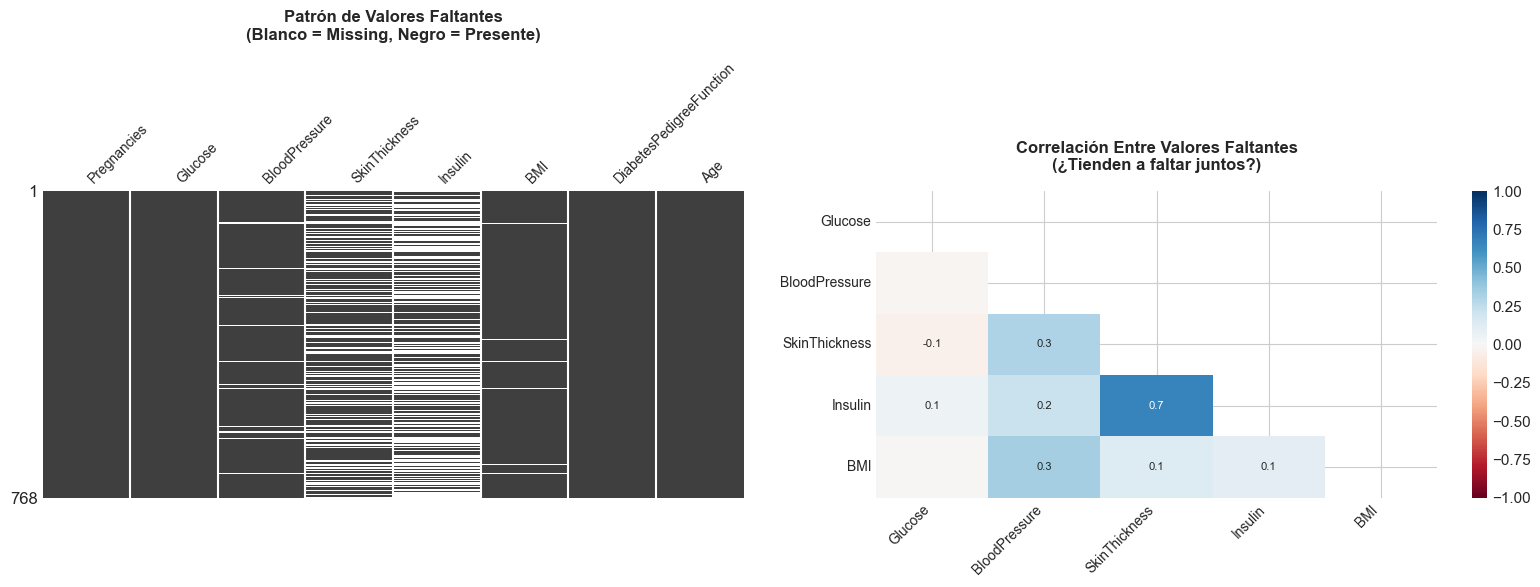

In [6]:
print("Instalando librería para visualización avanzada...")
try:
    import missingno as msno
    true_missingno = True
except:
    import subprocess
    subprocess.check_call(['pip','install','missingno'])
    import missingno as msno
    true_missingno = True

if true_missingno:
    fig, axes = plt.subplots(1, 2, figsize=(16,6))

    # Plot 1: Matrix de missing
    msno.matrix(df[features_cols], ax=axes[0], sparkline=True, fontsize=10)
    axes[0].set_title('Patrón de Valores Faltantes\n(Blanco = Missing, Negro = Presente)',
                     fontsize=12, fontweight='bold', pad=15)

    # Plot 2: Heatmap de correlación de missing
    msno.heatmap(df[features_cols], ax=axes[1], fontsize=10)
    axes[1].set_title('Correlación Entre Valores Faltantes\n(¿Tienden a faltar juntos?)',
                     fontsize=12, fontweight='bold', pad=15)

    plt.tight_layout()
    plt.savefig(FIGURES_DIR / '03_missing_patterns.png', dpi=300, bbox_inches='tight')
    print('¡Grafico guardado!')

________________________________________________________________________________ 

¿LOS VALORES FALTANTES OCURREN JUNTOS?
________________________________________________________________________________
Variables con missing: ['Insulin', 'SkinThickness', 'BloodPressure', 'BMI', 'Glucose']

Correlación de missing values:


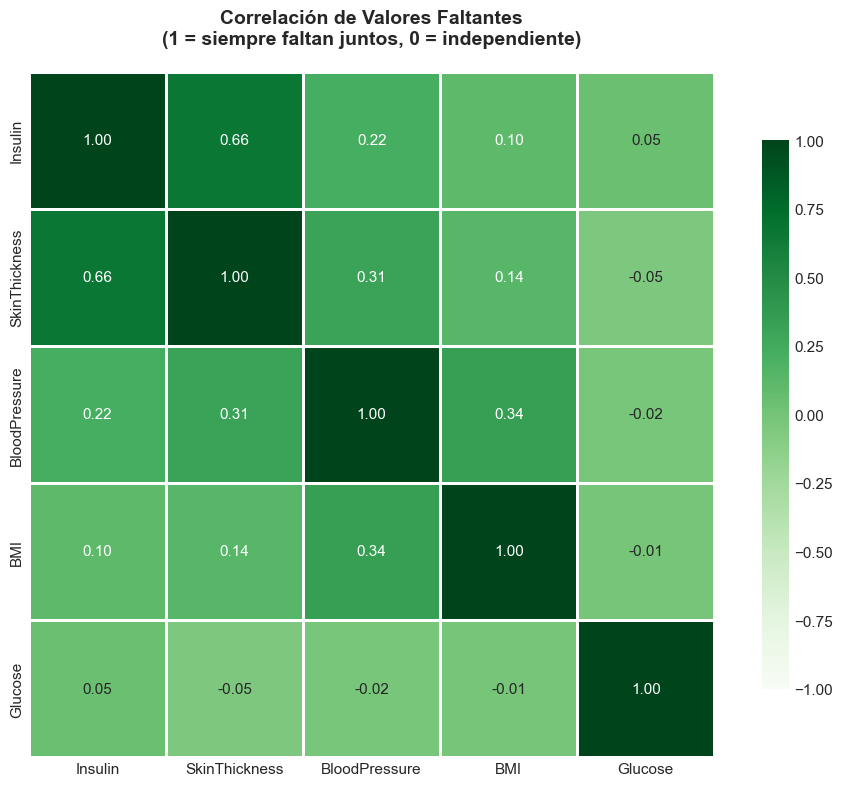

¡Grafico guardado!
INTERPRETACIÓN:
Insulin y SkinThickness tienden a faltar juntos (correlación positiva)
-> Probablemente se midieron en la misma prueba/visita


In [7]:
# ANÁLISIS DE CO-OCURRENCIA DE MISSING

print("_" * 80, "\n")
print("¿LOS VALORES FALTANTES OCURREN JUNTOS?")
print("_" * 80)


# Variables con missing significativo
vars_with_missing = df_comparison[df_comparison['NaN Después'] > 0 ]['Variable'].tolist()

print(f'Variables con missing: {vars_with_missing}\n')

# Análizar si faltan juntos  (ej: ¿cuando dalta Insulin también falta SkinThickness?)
if len(vars_with_missing) >= 2:
    print('Correlación de missing values:')
    missing_matrix = df[vars_with_missing].isna().astype(int)
    corr_missing = missing_matrix.corr()

    # Visualizar 
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(corr_missing, annot=True, fmt='.2f', cmap='Greens',
               center=0, square=True, linewidths=1, cbar_kws={'shrink':0.8}, 
               vmin=-1, vmax=1, ax=ax)
    ax.set_title('Correlación de Valores Faltantes\n(1 = siempre faltan juntos, 0 = independiente)',
                fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / '03_missing_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()
    print('¡Grafico guardado!')


    print('INTERPRETACIÓN:')
if corr_missing.loc['Insulin','SkinThickness'] > 0.3:
    print('Insulin y SkinThickness tienden a faltar juntos (correlación positiva)')
    print('-> Probablemente se midieron en la misma prueba/visita')
else:
    print('Los valores faltantes son mayormente independientes')

## Estrategias de Imputación {#imputacion}

Probaremos 3 métodos y compararemos:
1. **Imputación por Media** (Simple,rápida)
2. **Imputación por Mediana** (Robusta a outliers)
3. **Imputación por KNN** (Considera similitud entre observaciones)

**Criterio de evaluación:**
- Preservar distribuciones originales
- No introducir sesgo
- Mantener correlaciones
- Realismo clínico

### 6.1 Imputación por Media/Mediana {#media-mediana}

In [8]:
# MÉTODO 1: IMPUTACIÓN POR MEDIA

print("_" * 80, "\n")
print("MÉTODO 1: IMPUTACIÓN POR MEDIA")
print("_" * 80)

# Crear imputador
imputer_mean = SimpleImputer(strategy='mean')

# Aplicar solo a features (no al target)
df_imputed_mean = df.copy()
df_imputed_mean[features_cols] = imputer_mean.fit_transform(df[features_cols])

print('Imputación por media completada!')
print('Valores imputados (medias):')
for i, col in enumerate(features_cols):
    if col in vars_with_missing:
        mean_value = imputer_mean.statistics_[i]
        n_imputed = df[col].isna().sum()
        print(f'{col:20s}: {n_imputed:3d} valores -> {mean_value:.2f}')



#_______________________________________________________________________
# MÉTODO 2: IMPUTACIÓN POR MEDIANA

print("_" * 80, "\n")
print("MÉTODO 2: IMPUTACIÓN POR MEDIANA (Más robusta)")
print("_" * 80)

# Crear imputador
imputer_median = SimpleImputer(strategy='median')

# Aplicar
df_imputed_median = df.copy()
df_imputed_median[features_cols] = imputer_median.fit_transform(df[features_cols])

print('Imputación por media completada!')
print('Valores imputados (medianas):')
for i, col in enumerate(features_cols):
    if col in vars_with_missing:
        median_value = imputer_median.statistics_[i]
        n_imputed = df[col].isna().sum()
        print(f'{col:20s}: {n_imputed:3d} valores -> {median_value:.2f}')
        

________________________________________________________________________________ 

MÉTODO 1: IMPUTACIÓN POR MEDIA
________________________________________________________________________________
Imputación por media completada!
Valores imputados (medias):
Glucose             :   5 valores -> 121.69
BloodPressure       :  35 valores -> 72.41
SkinThickness       : 227 valores -> 29.15
Insulin             : 374 valores -> 155.55
BMI                 :  11 valores -> 32.46
________________________________________________________________________________ 

MÉTODO 2: IMPUTACIÓN POR MEDIANA (Más robusta)
________________________________________________________________________________
Imputación por media completada!
Valores imputados (medianas):
Glucose             :   5 valores -> 117.00
BloodPressure       :  35 valores -> 72.00
SkinThickness       : 227 valores -> 29.00
Insulin             : 374 valores -> 125.00
BMI                 :  11 valores -> 32.30


### 6.2 Imputación por KNN {#knn}

In [9]:
# MÉTODO 3: IMPUTACIÓN POR KNN (K-Nearest Neighbors)

print("_" * 80, "\n")
print("MÉTODO 3: IMPUTACIÓN POR KNN")
print("_" * 80)
print('Este método:')
print('- Encuentra las k observaciones más similares (vecinos)')
print('- Promedia sus valores para imputar')
print('- Preserva mejor las correlaciones entre variables')
print('- Más realista clínicamente\n')

# Crear imputador (k=5 vecinos)
imputer_knn = KNNImputer(n_neighbors=5, weights='distance')
print('Creando imputador...')
# Aplicar 
df_imputed_knn = df.copy()
df_imputed_knn[features_cols] = imputer_knn.fit_transform(df[features_cols])
print('Imputación completada!')

# Comparar valores imputados
print('COMPARACIÓN DE VALORES IMPUTADOS (primeras 5 filas con missing)')
print('Ejemplo: Insulin')

# Encontrar índices con Insulin missing
insulin_missing_idx = df[df['Insulin'].isna()].index[:5]

comparison_imputation = pd.DataFrame({
    'Original (NaN)': df.loc[insulin_missing_idx, 'Insulin'],
    'Media': df_imputed_mean.loc[insulin_missing_idx, 'Insulin'],
    'Mediana':df_imputed_median.loc[insulin_missing_idx, 'Insulin'],
    'KNN':df_imputed_knn.loc[insulin_missing_idx, 'Insulin']
})

display(comparison_imputation)

print('OBSERVACIÓN:')
print('Media/Mediana: Todos los missing reciben el MISMO valor')
print('KNN: Cada missing recibe un valor DIFERENTE basado en vecinos similares')
print('-> KNN es más realista (no todos los pacientes son idénticos)')

________________________________________________________________________________ 

MÉTODO 3: IMPUTACIÓN POR KNN
________________________________________________________________________________
Este método:
- Encuentra las k observaciones más similares (vecinos)
- Promedia sus valores para imputar
- Preserva mejor las correlaciones entre variables
- Más realista clínicamente

Creando imputador...
Imputación completada!
COMPARACIÓN DE VALORES IMPUTADOS (primeras 5 filas con missing)
Ejemplo: Insulin


,Original (NaN),Media,Mediana,KNN
0,NaN,155.548,125.0,166.000
1,NaN,155.548,125.0,60.705
2,NaN,155.548,125.0,172.109
5,NaN,155.548,125.0,104.600
7,NaN,155.548,125.0,133.925


OBSERVACIÓN:
Media/Mediana: Todos los missing reciben el MISMO valor
KNN: Cada missing recibe un valor DIFERENTE basado en vecinos similares
-> KNN es más realista (no todos los pacientes son idénticos)


### 6.3 Comparación de Métodos {#comparacion}

COMPARACIÓN VISUAL DE MÉTODOS DE IMPUTACIÓN


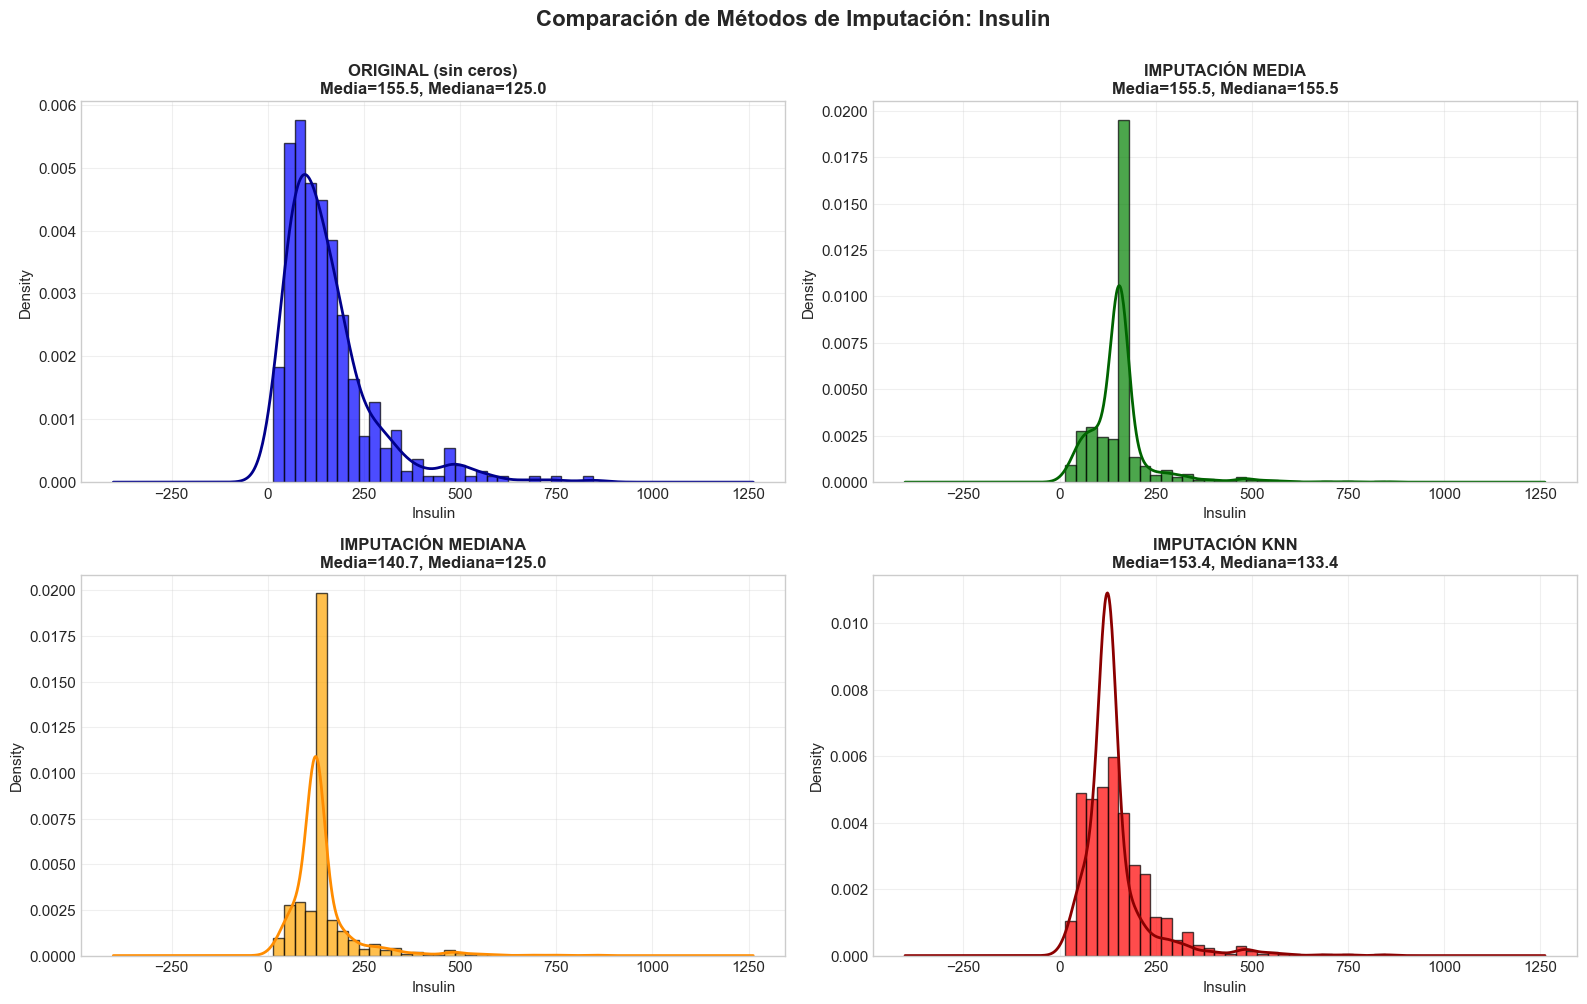

Grafico guardado!


In [12]:
print('COMPARACIÓN VISUAL DE MÉTODOS DE IMPUTACIÓN')

# Seleccionar la variable con más missing para comparar (Insulin)
var_to_compare = 'Insulin'

fig, axes = plt.subplots(2,2, figsize=(16,10))
axes = axes.flatten()

# Datos originales (sin los NaN)
original_data = df_before[df_before[var_to_compare] > 0][var_to_compare]

# Plot 1: Original (sin ceros)
axes[0].hist(original_data, bins=30, alpha=0.7, color='blue', edgecolor='black', density=True)
original_data.plot(kind='kde', ax=axes[0], color='darkblue', linewidth=2)
axes[0].set_title(f'ORIGINAL (sin ceros)\nMedia={original_data.mean():.1f}, Mediana={original_data.median():.1f}',
                 fontweight='bold', fontsize=12)
axes[0].set_xlabel(var_to_compare)
axes[0].grid(alpha=0.3)

# Plot 2: Imputación Media 
axes[1].hist(df_imputed_mean[var_to_compare], bins=30, alpha=0.7, color='green', edgecolor='black', density=True)
df_imputed_mean[var_to_compare].plot(kind='kde', ax=axes[1], color='darkgreen', linewidth=2)
axes[1].set_title(f'IMPUTACIÓN MEDIA\nMedia={df_imputed_mean[var_to_compare].mean():.1f}, Mediana={df_imputed_mean[var_to_compare].median():.1f}',
                 fontweight='bold', fontsize=12)
axes[1].set_xlabel(var_to_compare)
axes[1].grid(alpha=0.3)

# Plot 3: Imputación Mediana 
axes[2].hist(df_imputed_median[var_to_compare], bins=30, alpha=0.7, color='orange', edgecolor='black', density=True)
df_imputed_median[var_to_compare].plot(kind='kde', ax=axes[2], color='darkorange', linewidth=2)
axes[2].set_title(f'IMPUTACIÓN MEDIANA\nMedia={df_imputed_median[var_to_compare].mean():.1f}, Mediana={df_imputed_median[var_to_compare].median():.1f}',
                 fontweight='bold', fontsize=12)
axes[2].set_xlabel(var_to_compare)
axes[2].grid(alpha=0.3)

# Plot 4: Imputación KNN
axes[3].hist(df_imputed_knn[var_to_compare], bins=30, alpha=0.7, color='red', edgecolor='black', density=True)
df_imputed_median[var_to_compare].plot(kind='kde', ax=axes[3], color='darkred', linewidth=2)
axes[3].set_title(f'IMPUTACIÓN KNN\nMedia={df_imputed_knn[var_to_compare].mean():.1f}, Mediana={df_imputed_knn[var_to_compare].median():.1f}',
                 fontweight='bold', fontsize=12)
axes[3].set_xlabel(var_to_compare)
axes[3].grid(alpha=0.3)

plt.suptitle(f'Comparación de Métodos de Imputación: {var_to_compare}',
            fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.savefig(FIGURES_DIR / '03_imputation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('Grafico guardado!')

In [ ]:
print('EVALUACIÓN CUANTITATIVA DE MÉTODOS')

from scipy.stats import ks_2samp

# Para cada variable con missing, comparar distribuciones
evaluation_results = []

for col in vars_with_missing:
    # Datos originales (sin NaN/ceros)
    original = df_before[df_before[col] > 0][col]

    # Test de Kolmogorov-Smirnov (compara distribuciones)
    # H0: Las distribuciones son iguales
    # p-value alto (>0.05) = distribuciones similares

    ks_mean, p_mean = ks_2samp(original, df_imputed_mean[col])
    ks_median, p_median = ks_2samp(original, df_imputed_median[col])
    ks_knn, p_knn = ks_2samp(original, df_imputed_knn[col])

    # Diferencia de skewness
    skew_diff_mean = abs(df_imputed_mean[col].skew() - original.skew())
    skew_diff_median = abs(df_imputed_median[col].skew() - original.skew())
    skew_diff_knn = abs(df_imputed_knn[col].skew() - original.skew())

    evaluation_results.append({
        'Variable': col,
        'KS p-value (Media)': p_mean,
        'KS p-value (Mediana)': p_median,
        'KS p-value (KNN)': p_knn,
        'Skew (Media)': skew_diff_mean,
        'Skew (Mediana)': skew_diff_median,
        'Skew (KNN)': skew_diff_knn,
    })

df_evaluation = pd.DataFrame(evaluation_results)